# Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Data Cleaning / Analysis

In [3]:
# import file
df = pd.read_excel('tax-bracket.xlsx')
df.head(7)

,Income (Lower Bound),(Add.) Tax Rate,(Add.) Tax Flat,Category
0,0,0.10,0.0,Single Filer
1,10275,0.12,1027.5,Single Filer
2,41775,0.22,4807.5,Single Filer
3,89075,0.24,15213.5,Single Filer
4,170050,0.32,34647.5,Single Filer
5,215950,0.35,49335.5,Single Filer
6,539900,0.37,162718.0,Single Filer


In [4]:
# function to clean/filter down info
def df_select(df, category, factor):
    # extract relevant data and scale down to factor
    selected_df = df.loc[df['Category'] == category].reset_index().drop(['index','Category'], axis=1)
    selected_df[['Income (Lower Bound)', '(Add.) Tax Flat']] = selected_df[['Income (Lower Bound)', '(Add.) Tax Flat']]/factor
    return selected_df

In [5]:
# function to calc post_tax at any income
def tax_calc(income, selected_df):
    for i in range(len(selected_df.index)-1, -1, -1):
        if income > selected_df['Income (Lower Bound)'][i]:
            flat = selected_df['(Add.) Tax Flat'][i]
            marginal_tax_rate = selected_df['(Add.) Tax Rate'][i]
            taxable = income - selected_df['Income (Lower Bound)'][i]
            final_tax = (taxable * marginal_tax_rate) + flat
            return final_tax
    return 0

In [6]:
# function to generate post-tax arr
def tax_gen(df, arr, category, factor):
    # output vars
    post_tax = []
    tax = []

    selected_df = df_select(df, category, factor)

    # generate post-tax at every income
    for num in arr:
        post_tax.append(num - tax_calc(num, selected_df))
        tax.append(tax_calc(num, selected_df))

    # return output
    return [post_tax, tax]

In [7]:
# extract categories into ordered, unique list
cat_ls = []
for i in df['Category'].to_list():
    if i not in cat_ls:
        cat_ls.append(i)
cat_ls

['Single Filer',
 'Married Filer, Separate',
 'Head of Household',
 'Married Filer, Jointly']

# Data Viz

In [8]:
# create arr for graphing
max_income = 250000
factor = 1000
x = range(0, int(max_income/factor))
# post tax values
y_single = tax_gen(df, x, cat_ls[0], factor)[0]
y_marry_sepa = tax_gen(df, x, cat_ls[1], factor)[0]
y_head = tax_gen(df, x, cat_ls[2], factor)[0]
y_marry_join = tax_gen(df, x, cat_ls[3], factor)[0]
# tax values
y_Tsingle = tax_gen(df, x, cat_ls[0], factor)[1]
y_Tmarry_sepa = tax_gen(df, x, cat_ls[1], factor)[1]
y_Thead = tax_gen(df, x, cat_ls[2], factor)[1]
y_Tmarry_join = tax_gen(df, x, cat_ls[3], factor)[1]

In [9]:
# font setups
xm = 12
sm = 16
md = 24
lg = 30

plt.rc('font', size=sm)          # controls default text sizes
plt.rc('axes', titlesize=md)     # fontsize of the axes title
plt.rc('axes', labelsize=sm)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=sm)    # fontsize of the tick labels
plt.rc('ytick', labelsize=sm)    # fontsize of the tick labels
plt.rc('legend', fontsize=sm)    # legend fontsize
plt.rc('figure', titlesize=lg)   # fontsize of the figure title

In [10]:
# function to create thresholds
def thresh_gen(df, category, factor, max):
    # extract relevant rules
    selected_df = df_select(df, category, factor)

    # create thesholds
    income_thresh = []
    tax_thresh = []
    for i in range(0, len(selected_df.index)):
        if selected_df['Income (Lower Bound)'][i] < max/factor:
            income_thresh.append(selected_df['Income (Lower Bound)'][i])
            tax_thresh.append(selected_df['(Add.) Tax Rate'][i])
    return [income_thresh, tax_thresh]

In [11]:
# creating thresholds
bracket_single = thresh_gen(df, cat_ls[0], factor, max_income)
bracket_marry_sepa = thresh_gen(df, cat_ls[1], factor, max_income)
bracket_head = thresh_gen(df, cat_ls[2], factor, max_income)
bracket_marry_join = thresh_gen(df, cat_ls[3], factor, max_income)
brackets = [bracket_single, bracket_marry_sepa, bracket_head, bracket_marry_join]

C:\Users\CHRISM~1\AppData\Local\Temp/ipykernel_27104/3263012092.py:65: RuntimeWarning: invalid value encountered in double_scalars
  ax2.annotate(f'{round(y_pt,2)}, ETR:{round((y_pt/x_pt),2)*100}%', (x_pt+offset_x, y_pt+offset_y), c=color_dict[cat_ls[c]])


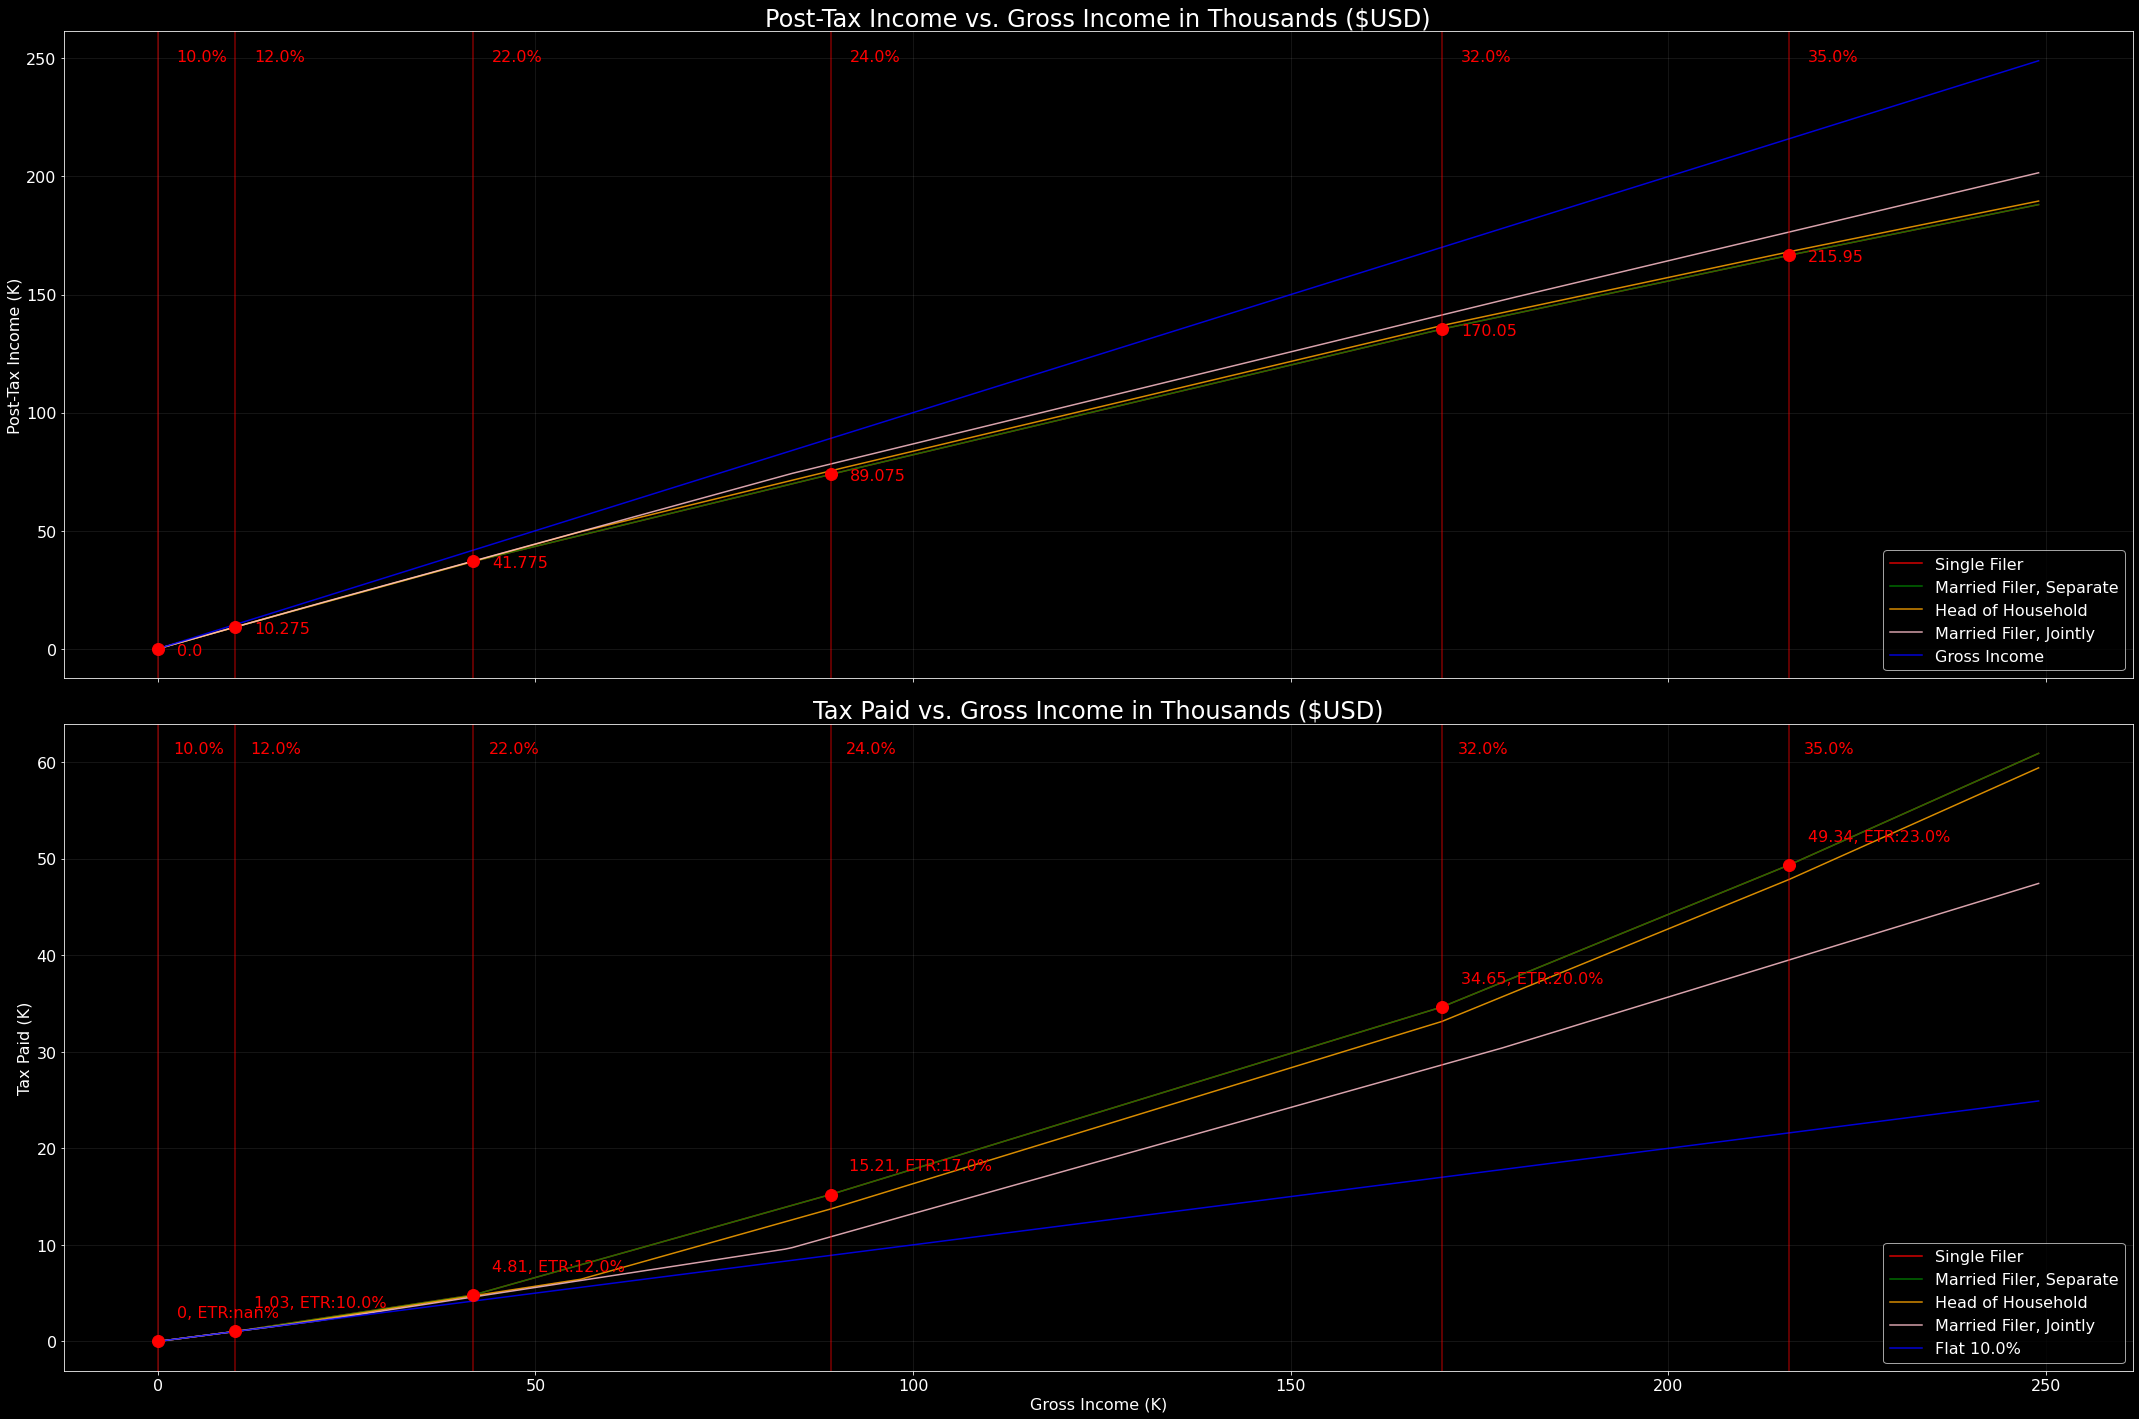

In [15]:
# ---------------
# figure setup
# ---------------
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(30,20))
plt.xlabel('Gross Income (K)')
color_dict = {
    cat_ls[0] : 'red',
    cat_ls[1] : 'green',
    cat_ls[2] : 'orange',
    cat_ls[3] : 'pink',
    'gross' : 'blue'
}

# ---------------
# post-tax income
# ---------------
# plot graphs
ax1.plot(x, y_single, alpha=0.85, label=cat_ls[0], c=color_dict[cat_ls[0]])
ax1.plot(x, y_marry_sepa, alpha=0.85, label=cat_ls[1], c=color_dict[cat_ls[1]])
ax1.plot(x, y_head, alpha=0.85, label=cat_ls[2], c=color_dict[cat_ls[2]])
ax1.plot(x, y_marry_join, alpha=0.85, label=cat_ls[3], c=color_dict[cat_ls[3]])
ax1.plot(x, x, alpha=0.85, label='Gross Income', c=color_dict['gross'])

#plotting thresholds
offset_x = max(x)/100
offset_y = max(x)/100

c = 0
for i in range(0, len(brackets[c][0])):
    #plot points
    x_pt = brackets[c][0][i]
    taxr = brackets[c][1][i]
    y_pt = x_pt - tax_calc(brackets[c][0][i], df_select(df, cat_ls[c], factor))
    ax1.plot(x_pt, y_pt, marker='o', markersize=12, markeredgecolor=color_dict[cat_ls[c]], markerfacecolor=color_dict[cat_ls[c]])
    ax1.annotate(f'{x_pt}', (x_pt+offset_x, y_pt-offset_y), c=color_dict[cat_ls[c]])
    
    #show marginal tax rate bracket
    ax1.axvline(x_pt, alpha=0.5, c=color_dict[cat_ls[c]])
    ax1.annotate(f"{str(taxr*100)}%", (x_pt+offset_x, max(x)), c=color_dict[cat_ls[c]])

#setup
ax1.set_ylabel('Post-Tax Income (K)')
ax1.set_title('Post-Tax Income vs. Gross Income in Thousands ($USD)')
ax1.legend()
ax1.grid(alpha=0.1)

# ---------------
# tax paid
# ---------------
# plot graphs
flat_per = .1
ax2.plot(x, y_Tsingle, alpha=0.85, label=cat_ls[0], c=color_dict[cat_ls[0]])
ax2.plot(x, y_Tmarry_sepa, alpha=0.85, label=cat_ls[1], c=color_dict[cat_ls[1]])
ax2.plot(x, y_Thead, alpha=0.85, label=cat_ls[2], c=color_dict[cat_ls[2]])
ax2.plot(x, y_Tmarry_join, alpha=0.85, label=cat_ls[3], c=color_dict[cat_ls[3]])
ax2.plot(x, [i*flat_per for i in x], alpha=0.85, label=f'Flat {flat_per*100}%', c=color_dict['gross'])

#plotting thresholds
for i in range(0, len(brackets[c][0])):
    #plot points
    x_pt = brackets[c][0][i]
    taxr = brackets[c][1][i]
    y_pt = tax_calc(brackets[c][0][i], df_select(df, cat_ls[c], factor))
    ax2.plot(x_pt, y_pt, marker='o', markersize=12, markeredgecolor=color_dict[cat_ls[c]], markerfacecolor=color_dict[cat_ls[c]])
    ax2.annotate(f'{round(y_pt,2)}, ETR:{round((y_pt/x_pt),2)*100}%', (x_pt+offset_x, y_pt+offset_y), c=color_dict[cat_ls[c]])
    
    #show marginal tax rate bracket
    ax2.axvline(x_pt, alpha=0.5, c=color_dict[cat_ls[c]])
    ax2.annotate(f"{str(taxr*100)}%", (x_pt+2, max(y_Tsingle)), c=color_dict[cat_ls[c]])

#setup
ax2.set_ylabel('Tax Paid (K)')
ax2.set_title('Tax Paid vs. Gross Income in Thousands ($USD)')
ax2.legend()
ax2.grid(alpha=0.1)

# ---------------
# figure setup 2
# ---------------
plt.tight_layout()
plt.savefig('output.png')